Import libraries

In [1]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.0/715.0 kB 17.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from IPython.core.magic import register_line_cell_magic
import yaml
from PIL import Image
import os
import seaborn as sns
from ultralytics import YOLO
from matplotlib.patches import Rectangle
import glob
import cv2


In [3]:
warnings.filterwarnings("ignore")

np.random.seed(12345)

%matplotlib inline

!wandb disabled

W&B disabled.


In [4]:
INPUT_DIR = '/kaggle/input/slefdri'
WORK_DIR = '/kaggle/working/'

Data Exploration

In [5]:
# Create data YAML file
num_classes = 7
classes = ['biker', 'car', 'pedestrian', 'traffic light', 'trafficlight-green', 'trafficlight-red', 'truck']

In [6]:
dict_file = {'train': os.path.join(INPUT_DIR, 'train'),
             'val': os.path.join(INPUT_DIR, 'valid'),
             'test': os.path.join(INPUT_DIR, 'test'),
             'nc': num_classes,
             'names': classes
            }

with open(os.path.join(WORK_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [7]:
# Check class balance
class_idx = {str(i):classes[i] for i in range(num_classes)}

class_stat = {}
data_len = {}

for mode in ['train', 'valid', 'test']:

    class_count = {classes[i]:0 for i in range(num_classes)}

    path = os.path.join(INPUT_DIR, mode, 'labels')

    for file in os.listdir(path):

        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1
                
    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

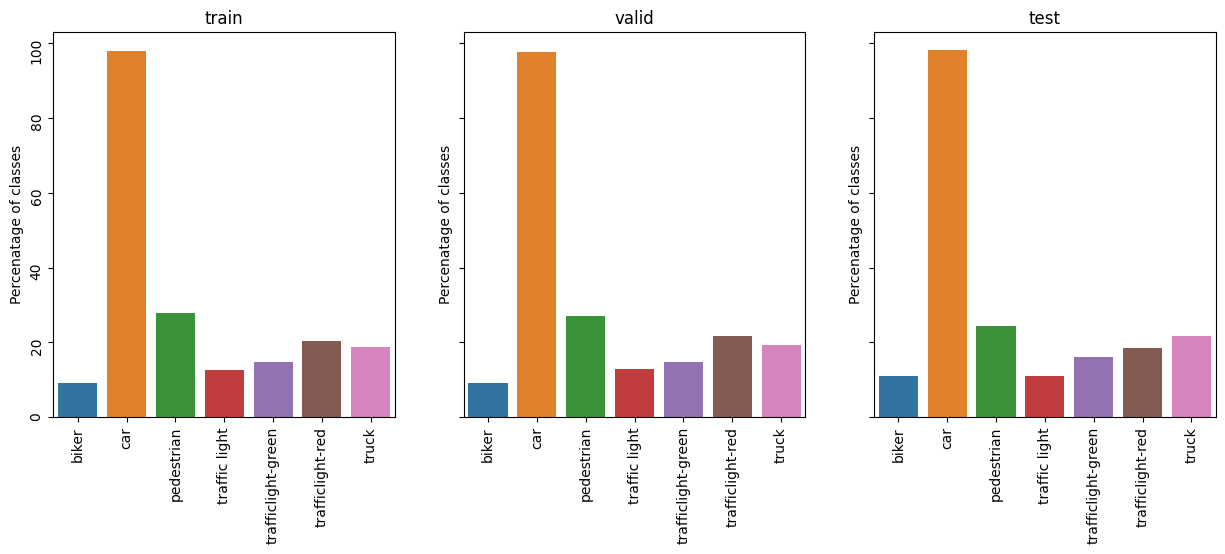

In [8]:
fig, ax = plt.subplots(1,3, figsize=(15, 5), sharey=True)

for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(pd.DataFrame({mode:class_stat[mode]}).T/data_len[mode]*100, ax=ax[i])
    ax[i].set_title(mode)
    ax[i].tick_params(rotation=90)
    ax[i].set_ylabel('Percenatage of classes')
plt.show()

In [9]:
# Check image sizes
for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:\n')
    img_size = 0
    for file in glob.glob(os.path.join(INPUT_DIR, mode, 'images', '*')):
        image = Image.open(file)
        if image.size != img_size:
#             print(f'\t{image.size}')
            img_size = image.size


Image sizes in train set:


Image sizes in valid set:


Image sizes in test set:



In [10]:
# Check dataset sizes
for mode in ['train', 'valid', 'test']:
    
    files =  glob.glob(os.path.join(INPUT_DIR, mode, 'images', '*'))
        
    print(f'{mode} set size: {len(files)}\n')

train set size: 5148

valid set size: 1468

test set size: 742



Train model

In [11]:
# Load model
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 113MB/s]


In [12]:
model.train(data=os.path.join(WORK_DIR,'data.yaml'),
            task='detect',
            imgsz=640,
            epochs=500,
            batch=16,
            mode='train',
            name='yolov8n_v0_train')

Ultralytics YOLOv8.1.14 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=500, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v0_train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_

100%|██████████| 755k/755k [00:00<00:00, 22.6MB/s]
2024-02-16 18:46:31,553	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-02-16 18:46:32,341	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-02-16 18:46:34.712739: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 18:46:34.712835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 18:46:34.831028: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/slefdri/train/labels... 5148 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5148/5148 [00:04<00:00, 1121.14it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/slefdri/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/slefdri/valid/labels... 1468 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1468/1468 [00:01<00:00, 995.37it/s] 

val: WARNING ⚠️ Cache directory /kaggle/input/slefdri/valid is not writeable, cache not saved.


Plotting labels to runs/detect/yolov8n_v0_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_v0_train
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500      2.49G      1.631      2.088      1.221         83        640: 100%|██████████| 322/322 [01:09<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:12<00:00,  3.58it/s]


                   all       1468      10567      0.504      0.341      0.299      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/500       2.4G      1.578      1.423      1.196        114        640: 100%|██████████| 322/322 [01:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.10it/s]


                   all       1468      10567      0.413      0.369      0.347      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500      2.34G      1.601      1.388      1.208         65        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.23it/s]


                   all       1468      10567      0.453      0.411       0.36      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/500      2.43G      1.613      1.323      1.217        140        640: 100%|██████████| 322/322 [01:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.61it/s]


                   all       1468      10567      0.445      0.395       0.35      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/500      2.44G      1.594      1.229      1.202        115        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]


                   all       1468      10567      0.487      0.445      0.431      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/500      2.41G      1.586      1.175      1.202        186        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]


                   all       1468      10567      0.554       0.46      0.461      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/500      2.39G       1.57       1.13      1.197        114        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]


                   all       1468      10567      0.572      0.468       0.47      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/500       2.4G      1.564      1.108      1.193        138        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]


                   all       1468      10567      0.591      0.471      0.499      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/500      2.41G      1.541      1.074      1.187        118        640: 100%|██████████| 322/322 [01:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.586      0.471      0.496      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/500      2.43G      1.531      1.058      1.179         62        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567      0.603      0.481      0.504      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/500      2.42G      1.521      1.034      1.173         96        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.611      0.467      0.508      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/500      2.34G      1.512      1.026      1.173        135        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]


                   all       1468      10567      0.651      0.484      0.536       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/500      2.34G      1.509       1.01      1.166        103        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]


                   all       1468      10567      0.593      0.485      0.511      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/500      2.41G      1.501      0.999      1.163        135        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.60it/s]


                   all       1468      10567      0.583      0.522      0.527      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/500      2.42G      1.503     0.9898      1.161        145        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567       0.58      0.498      0.533       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/500      2.34G      1.491     0.9752      1.158        100        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]


                   all       1468      10567      0.602      0.538      0.539      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/500      2.34G      1.479     0.9671      1.155         99        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]

                   all       1468      10567      0.662      0.527      0.575       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/500      2.41G      1.478     0.9663       1.15        105        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]

                   all       1468      10567      0.616      0.542       0.56      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/500      2.42G      1.475     0.9557      1.151         90        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]


                   all       1468      10567      0.628      0.552      0.577      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/500       2.4G      1.458     0.9425      1.143        129        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.637      0.562       0.58      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/500      2.39G      1.467     0.9425      1.144         91        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]


                   all       1468      10567      0.624      0.569      0.594      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/500       2.4G      1.464     0.9369      1.146        144        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]


                   all       1468      10567      0.643      0.569      0.597      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/500       2.4G      1.457     0.9272      1.143        122        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]


                   all       1468      10567      0.682      0.551      0.596      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/500      2.34G      1.453     0.9252      1.134        165        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]


                   all       1468      10567       0.67      0.571      0.605      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/500      2.41G      1.449     0.9166      1.139        143        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]

                   all       1468      10567      0.675      0.539      0.599      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/500       2.4G      1.451     0.9157      1.138        182        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]


                   all       1468      10567      0.664      0.551      0.595      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/500      2.41G      1.447     0.9093      1.136         81        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]


                   all       1468      10567      0.661      0.545      0.601      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/500      2.41G      1.431     0.9004      1.127        102        640: 100%|██████████| 322/322 [01:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]

                   all       1468      10567      0.662      0.562      0.603      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/500      2.42G      1.432     0.9051      1.132        135        640: 100%|██████████| 322/322 [01:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.58it/s]


                   all       1468      10567      0.658       0.57      0.617       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/500      2.43G      1.432     0.8955      1.127        123        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]


                   all       1468      10567      0.648      0.544      0.585      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/500      2.43G      1.431     0.8925      1.129         66        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567      0.724      0.577      0.635      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/500      2.42G      1.422     0.8894      1.127        178        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.58it/s]


                   all       1468      10567      0.706      0.561      0.624      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/500      2.34G      1.421      0.881      1.127         86        640: 100%|██████████| 322/322 [01:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567      0.665      0.573      0.617       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/500       2.4G      1.423     0.8892      1.124        101        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.59it/s]


                   all       1468      10567      0.681      0.577      0.626      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/500       2.4G      1.414     0.8807       1.12        132        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]


                   all       1468      10567      0.691      0.569      0.624      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/500      2.42G       1.41     0.8721      1.114         91        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]

                   all       1468      10567      0.692      0.569      0.634      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/500       2.4G      1.416     0.8726      1.122        160        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]


                   all       1468      10567      0.703      0.596      0.647      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/500      2.41G      1.406     0.8691      1.121        112        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.685      0.586      0.633      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/500       2.4G      1.402     0.8687      1.117        113        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.62it/s]


                   all       1468      10567      0.725      0.571      0.637      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/500      2.34G      1.416     0.8744      1.123        111        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.52it/s]

                   all       1468      10567      0.717      0.594      0.645      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/500      2.39G      1.405     0.8642      1.116        126        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.55it/s]


                   all       1468      10567      0.702      0.594      0.642      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/500      2.34G      1.398     0.8647      1.111        132        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]

                   all       1468      10567       0.71      0.603      0.642      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/500      2.39G      1.389      0.854       1.11        121        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.61it/s]


                   all       1468      10567      0.709      0.598      0.645      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/500      2.34G      1.401     0.8546      1.112        120        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567      0.718      0.608       0.66      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/500      2.39G       1.39     0.8472      1.105        134        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]


                   all       1468      10567      0.702      0.614      0.658      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/500       2.4G      1.384     0.8432      1.107        139        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]


                   all       1468      10567      0.732      0.611      0.667      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/500      2.41G      1.387     0.8469       1.11        148        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]


                   all       1468      10567      0.741      0.602      0.668      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/500      2.34G      1.388     0.8447      1.108         98        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]

                   all       1468      10567      0.741      0.607      0.668      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/500      2.41G      1.387     0.8361      1.108         65        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.50it/s]


                   all       1468      10567       0.72      0.609      0.658      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/500       2.4G      1.383     0.8416      1.101        115        640: 100%|██████████| 322/322 [01:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.57it/s]

                   all       1468      10567      0.705      0.635      0.672      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/500      2.39G      1.375     0.8367      1.103        119        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.55it/s]


                   all       1468      10567      0.724      0.612      0.665      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/500      2.43G      1.377     0.8337      1.103         93        640: 100%|██████████| 322/322 [01:01<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.743      0.611      0.673      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/500      2.34G      1.379     0.8319      1.103         84        640: 100%|██████████| 322/322 [01:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.755       0.61      0.682      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/500      2.34G      1.363     0.8248      1.097        188        640: 100%|██████████| 322/322 [01:02<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567      0.729      0.628      0.679      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/500      2.34G      1.374     0.8286        1.1         77        640: 100%|██████████| 322/322 [01:02<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.81it/s]


                   all       1468      10567       0.74      0.622       0.68      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/500      2.34G      1.371     0.8222      1.096        145        640: 100%|██████████| 322/322 [01:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.60it/s]


                   all       1468      10567      0.717      0.624       0.68      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/500       2.4G      1.364     0.8244      1.099        130        640: 100%|██████████| 322/322 [01:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]


                   all       1468      10567      0.752      0.619      0.684       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/500      2.39G      1.368     0.8219      1.096        190        640: 100%|██████████| 322/322 [01:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]


                   all       1468      10567      0.787      0.607      0.688      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/500      2.41G      1.367     0.8236      1.095        110        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]

                   all       1468      10567      0.726      0.624      0.673      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/500      2.41G      1.365     0.8198      1.094        117        640: 100%|██████████| 322/322 [01:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]


                   all       1468      10567      0.755      0.616      0.688      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/500      2.34G      1.362     0.8174      1.097         86        640: 100%|██████████| 322/322 [01:02<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]


                   all       1468      10567      0.716       0.63      0.682      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/500      2.34G      1.355     0.8104      1.094        100        640: 100%|██████████| 322/322 [01:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.79it/s]


                   all       1468      10567      0.759      0.627      0.693      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/500      2.41G      1.358     0.8125      1.092        134        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]


                   all       1468      10567      0.757      0.614      0.697      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/500      2.43G      1.354     0.8147      1.093        124        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]


                   all       1468      10567      0.773      0.616      0.696      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/500       2.4G      1.352     0.8073      1.091        135        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.81it/s]


                   all       1468      10567      0.768      0.623      0.692      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/500      2.43G      1.349      0.809      1.091        104        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567      0.765      0.636      0.701      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/500       2.4G      1.355     0.8073      1.095        117        640: 100%|██████████| 322/322 [01:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]


                   all       1468      10567      0.744      0.633      0.692      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/500      2.34G      1.348     0.8032      1.086         93        640: 100%|██████████| 322/322 [01:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567      0.773      0.612      0.698       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/500      2.41G      1.349     0.8036       1.09        129        640: 100%|██████████| 322/322 [01:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]


                   all       1468      10567      0.753      0.636      0.694      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/500       2.4G      1.345     0.8024      1.086        117        640: 100%|██████████| 322/322 [01:03<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]


                   all       1468      10567      0.752      0.631      0.695      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/500      2.39G      1.345     0.7934      1.089        151        640: 100%|██████████| 322/322 [01:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.32it/s]


                   all       1468      10567      0.781      0.632      0.707      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/500      2.39G      1.347     0.8004      1.084        125        640: 100%|██████████| 322/322 [01:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.55it/s]


                   all       1468      10567      0.754      0.643      0.705      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/500      2.41G       1.34     0.8011      1.088        139        640: 100%|██████████| 322/322 [01:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.767      0.641      0.715       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/500      2.41G      1.344     0.7989      1.086        121        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]


                   all       1468      10567      0.756      0.657      0.712      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/500      2.42G      1.337     0.7956      1.086         87        640: 100%|██████████| 322/322 [01:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.79it/s]


                   all       1468      10567      0.758      0.645      0.714      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/500      2.41G      1.335     0.7916      1.084        152        640: 100%|██████████| 322/322 [01:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567      0.793      0.627      0.711      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/500      2.39G      1.334     0.7889      1.082        125        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.79it/s]


                   all       1468      10567      0.773      0.634      0.708      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/500      2.42G      1.333     0.7829      1.082        129        640: 100%|██████████| 322/322 [01:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567       0.78      0.625       0.71       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/500      2.41G      1.333     0.7895      1.084        167        640: 100%|██████████| 322/322 [01:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]

                   all       1468      10567      0.776      0.644      0.712      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/500      2.55G      1.327     0.7827      1.079        100        640: 100%|██████████| 322/322 [01:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567      0.783      0.639      0.716      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/500      2.34G      1.331     0.7865      1.083        117        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]


                   all       1468      10567       0.78       0.64      0.718      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/500      2.39G      1.327     0.7837      1.082        127        640: 100%|██████████| 322/322 [01:01<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]


                   all       1468      10567      0.794      0.636      0.717      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/500      2.34G      1.329     0.7842      1.082        105        640: 100%|██████████| 322/322 [01:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.40it/s]

                   all       1468      10567      0.779      0.643      0.717      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/500      2.34G      1.323       0.78      1.079        116        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.60it/s]


                   all       1468      10567      0.779      0.668      0.722      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/500      2.41G      1.327     0.7851       1.08        122        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.41it/s]


                   all       1468      10567       0.78      0.652      0.721      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/500      2.34G      1.323     0.7754      1.077        121        640: 100%|██████████| 322/322 [01:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.37it/s]


                   all       1468      10567      0.789      0.646       0.72      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/500      2.49G      1.331     0.7815      1.076        130        640: 100%|██████████| 322/322 [01:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.79it/s]


                   all       1468      10567      0.775      0.642      0.715      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/500      2.34G      1.323     0.7806      1.077        122        640: 100%|██████████| 322/322 [01:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.779      0.652      0.728      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/500      2.41G      1.321     0.7749      1.076        117        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.61it/s]

                   all       1468      10567      0.787      0.654      0.725      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/500       2.4G      1.319     0.7731      1.076        113        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]


                   all       1468      10567      0.778      0.663      0.731      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/500       2.4G      1.317     0.7699      1.074        118        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567      0.783      0.663      0.728      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/500      2.39G      1.313     0.7729      1.074        134        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567       0.81      0.644      0.723        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/500      2.34G      1.324     0.7717      1.078         87        640: 100%|██████████| 322/322 [01:02<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]


                   all       1468      10567      0.785      0.668      0.726      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/500      2.39G      1.313     0.7705      1.073         69        640: 100%|██████████| 322/322 [01:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]

                   all       1468      10567      0.776      0.652      0.722        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/500      2.49G      1.312     0.7663      1.074        142        640: 100%|██████████| 322/322 [01:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567       0.77      0.664      0.723      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/500       2.4G      1.311     0.7635       1.07        124        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]

                   all       1468      10567      0.781      0.659      0.725        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/500      2.42G      1.309     0.7596      1.073         99        640: 100%|██████████| 322/322 [01:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]


                   all       1468      10567      0.787      0.652      0.722      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/500       2.4G      1.308     0.7637      1.073        147        640: 100%|██████████| 322/322 [01:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]


                   all       1468      10567      0.799      0.658       0.73      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/500       2.4G      1.308     0.7593       1.07        100        640: 100%|██████████| 322/322 [01:02<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.60it/s]


                   all       1468      10567      0.778      0.668      0.729      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/500       2.4G       1.31     0.7627      1.069        148        640: 100%|██████████| 322/322 [01:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]

                   all       1468      10567      0.796      0.656      0.731      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/500      2.42G      1.304     0.7634      1.069        166        640: 100%|██████████| 322/322 [01:02<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]

                   all       1468      10567      0.796      0.661       0.73      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/500      2.39G      1.309     0.7629      1.074         99        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]

                   all       1468      10567      0.795      0.664      0.734       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/500       2.4G      1.303     0.7602      1.074        149        640: 100%|██████████| 322/322 [01:02<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]

                   all       1468      10567        0.8      0.661      0.737      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/500      2.34G      1.301     0.7579      1.067        155        640: 100%|██████████| 322/322 [01:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.50it/s]

                   all       1468      10567      0.806      0.656      0.737      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/500       2.4G      1.309     0.7518      1.069        160        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.35it/s]


                   all       1468      10567      0.803      0.659      0.737      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/500       2.4G      1.303     0.7567      1.066        140        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.22it/s]


                   all       1468      10567      0.806      0.649      0.735       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/500      2.39G        1.3     0.7513      1.067        121        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.52it/s]

                   all       1468      10567      0.797      0.664      0.737      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/500      2.42G      1.295     0.7518      1.068        122        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.61it/s]

                   all       1468      10567      0.801      0.659      0.737      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/500      2.41G      1.295     0.7554      1.064        104        640: 100%|██████████| 322/322 [01:02<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.62it/s]


                   all       1468      10567      0.806      0.653      0.736      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/500      2.41G      1.293     0.7499      1.063        122        640: 100%|██████████| 322/322 [01:02<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]


                   all       1468      10567      0.794      0.663      0.738      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/500       2.4G      1.294     0.7493      1.063        136        640: 100%|██████████| 322/322 [01:02<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.81it/s]


                   all       1468      10567      0.805      0.654      0.734       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/500      2.41G      1.296     0.7523      1.065        106        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567      0.796      0.667      0.736      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/500      2.39G      1.293     0.7529      1.063        140        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567      0.799      0.662      0.735      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/500      2.42G      1.293     0.7484      1.064        101        640: 100%|██████████| 322/322 [01:02<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]

                   all       1468      10567      0.795      0.666      0.738      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/500      2.42G      1.286     0.7441      1.061         66        640: 100%|██████████| 322/322 [01:02<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.84it/s]


                   all       1468      10567      0.788      0.679       0.74      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/500      2.51G      1.285     0.7472      1.063         88        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]


                   all       1468      10567      0.793      0.674      0.738      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/500       2.4G      1.281     0.7457      1.059        134        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567      0.796      0.671      0.743      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/500      2.39G      1.285     0.7471      1.063        130        640: 100%|██████████| 322/322 [01:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.82it/s]


                   all       1468      10567      0.798      0.676      0.747      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/500      2.34G       1.29     0.7449      1.062        124        640: 100%|██████████| 322/322 [01:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]

                   all       1468      10567      0.797      0.674      0.744      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/500      2.43G      1.283     0.7428      1.057        145        640: 100%|██████████| 322/322 [01:02<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]

                   all       1468      10567      0.796      0.679      0.744      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/500      2.34G      1.283     0.7423      1.062         80        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]

                   all       1468      10567      0.805      0.673      0.745      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/500      2.34G      1.283     0.7413      1.063        129        640: 100%|██████████| 322/322 [01:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567       0.81      0.671      0.745      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/500      2.39G      1.282     0.7337      1.059        153        640: 100%|██████████| 322/322 [01:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]


                   all       1468      10567      0.793      0.673      0.744      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/500      2.42G      1.277     0.7336      1.055        103        640: 100%|██████████| 322/322 [01:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]


                   all       1468      10567      0.808      0.671      0.744      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/500      2.42G      1.283     0.7394      1.057        121        640: 100%|██████████| 322/322 [01:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]


                   all       1468      10567      0.804      0.672      0.745      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/500       2.4G      1.277     0.7385      1.056         95        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]


                   all       1468      10567      0.787      0.681      0.745      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/500      2.34G       1.28     0.7378      1.059        164        640: 100%|██████████| 322/322 [01:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]


                   all       1468      10567      0.794      0.671      0.746      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/500      2.43G      1.278     0.7403      1.059        119        640: 100%|██████████| 322/322 [01:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567      0.798      0.669      0.746      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/500      2.39G      1.279     0.7398      1.061         84        640: 100%|██████████| 322/322 [01:02<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567        0.8      0.674      0.746      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/500       2.4G      1.274     0.7314      1.052        167        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567      0.808      0.668      0.746      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/500      2.41G      1.278     0.7392      1.058        146        640: 100%|██████████| 322/322 [01:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]

                   all       1468      10567      0.799      0.676      0.746      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/500      2.39G      1.275     0.7356      1.054         93        640: 100%|██████████| 322/322 [01:02<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]


                   all       1468      10567       0.79       0.68      0.746       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/500       2.4G      1.267     0.7293      1.052        108        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.81it/s]


                   all       1468      10567      0.783      0.687      0.746       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/500      2.41G      1.273     0.7324      1.055        121        640: 100%|██████████| 322/322 [01:03<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]

                   all       1468      10567      0.795      0.684      0.748       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/500      2.34G      1.259     0.7285      1.054        127        640: 100%|██████████| 322/322 [01:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]

                   all       1468      10567      0.803      0.675      0.746       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/500      2.34G      1.269     0.7274      1.054        129        640: 100%|██████████| 322/322 [01:02<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]


                   all       1468      10567      0.806      0.677      0.748      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/500      2.41G      1.266     0.7222      1.052        158        640: 100%|██████████| 322/322 [01:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567      0.797      0.683      0.747      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/500      2.34G      1.263      0.727      1.055         90        640: 100%|██████████| 322/322 [01:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.81it/s]


                   all       1468      10567      0.802      0.682      0.749      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/500      2.41G      1.266     0.7237      1.052        142        640: 100%|██████████| 322/322 [01:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]


                   all       1468      10567      0.807      0.679      0.747      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/500       2.4G      1.261     0.7244      1.053         83        640: 100%|██████████| 322/322 [01:02<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.82it/s]


                   all       1468      10567      0.797      0.688      0.748      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/500      2.39G      1.272     0.7279      1.054         86        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567      0.795      0.688       0.75      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/500      2.41G      1.259     0.7245      1.053        147        640: 100%|██████████| 322/322 [01:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.62it/s]


                   all       1468      10567      0.807      0.682       0.75      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/500      2.34G      1.262     0.7225      1.053         77        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567      0.811      0.682      0.751      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/500      2.34G      1.262     0.7225      1.049        162        640: 100%|██████████| 322/322 [01:03<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]

                   all       1468      10567      0.808      0.688      0.753      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/500       2.5G      1.259     0.7199      1.052        106        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567      0.808      0.688      0.754      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/500       2.4G      1.268      0.725      1.053        110        640: 100%|██████████| 322/322 [01:02<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]


                   all       1468      10567      0.807      0.697      0.756      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/500      2.41G      1.258     0.7206      1.049         97        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.20it/s]


                   all       1468      10567      0.809      0.691      0.755      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/500      2.39G      1.253     0.7173      1.047        184        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]


                   all       1468      10567      0.813      0.685      0.753      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/500       2.4G      1.258      0.716      1.048        100        640: 100%|██████████| 322/322 [01:02<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]


                   all       1468      10567      0.816      0.688      0.754      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/500      2.39G      1.255     0.7125      1.048         91        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]


                   all       1468      10567      0.816       0.69      0.757      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/500      2.39G      1.256     0.7209       1.05         94        640: 100%|██████████| 322/322 [01:03<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567      0.815      0.686      0.756      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/500      2.39G      1.259     0.7238       1.05        107        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]

                   all       1468      10567      0.821      0.682      0.755      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/500      2.39G      1.255     0.7124      1.049        118        640: 100%|██████████| 322/322 [01:02<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]


                   all       1468      10567      0.815      0.687      0.756      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/500      2.42G      1.258     0.7173      1.049         91        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567      0.817      0.685      0.756      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/500      2.51G       1.25     0.7153      1.047        120        640: 100%|██████████| 322/322 [01:03<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]


                   all       1468      10567      0.818      0.685      0.757      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/500      2.42G      1.248      0.711      1.048        116        640: 100%|██████████| 322/322 [01:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]


                   all       1468      10567      0.806      0.691      0.756      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/500      2.34G      1.248     0.7039      1.046        120        640: 100%|██████████| 322/322 [01:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]


                   all       1468      10567      0.804      0.693      0.757      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/500      2.34G      1.242     0.7048      1.044        121        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567      0.806      0.693      0.758       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/500      2.41G      1.249     0.7105      1.048        140        640: 100%|██████████| 322/322 [01:03<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567      0.807      0.694       0.76       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/500      2.34G      1.248     0.7099      1.045        122        640: 100%|██████████| 322/322 [01:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.19it/s]

                   all       1468      10567      0.812      0.689      0.759       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/500       2.4G      1.247     0.7072      1.041        108        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]


                   all       1468      10567      0.813      0.692      0.761      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/500      2.41G      1.241     0.7091      1.042        112        640: 100%|██████████| 322/322 [01:02<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.45it/s]

                   all       1468      10567      0.808      0.696      0.761       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/500      2.41G      1.245     0.7087      1.044        143        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.59it/s]


                   all       1468      10567      0.815      0.691       0.76       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/500       2.4G      1.241     0.7057      1.039        137        640: 100%|██████████| 322/322 [01:03<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]


                   all       1468      10567       0.82      0.689       0.76       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/500       2.4G      1.244      0.708      1.047        105        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]


                   all       1468      10567      0.821      0.691      0.761      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/500      2.39G      1.245     0.7053      1.045        162        640: 100%|██████████| 322/322 [01:03<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]


                   all       1468      10567      0.816      0.691       0.76      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/500      2.41G      1.241     0.7112      1.045        137        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567       0.83      0.683      0.758      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/500      2.41G      1.241     0.7082      1.043        143        640: 100%|██████████| 322/322 [01:03<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]


                   all       1468      10567      0.823      0.685      0.759      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/500       2.4G      1.242     0.7029      1.042         93        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]

                   all       1468      10567      0.807      0.692      0.758      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/500      2.34G      1.229     0.6996      1.041        154        640: 100%|██████████| 322/322 [01:03<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]

                   all       1468      10567      0.816      0.689      0.758      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/500       2.4G      1.238     0.7044      1.041        137        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.823      0.684      0.757      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/500      2.34G      1.231     0.7001      1.035        134        640: 100%|██████████| 322/322 [01:03<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.79it/s]


                   all       1468      10567      0.823      0.686      0.758      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/500      2.39G      1.235     0.6962      1.042        118        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]


                   all       1468      10567      0.824      0.687      0.758      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/500      2.42G      1.238      0.699      1.041        118        640: 100%|██████████| 322/322 [01:03<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]

                   all       1468      10567      0.822      0.686      0.758      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/500       2.4G      1.239     0.7042      1.043        161        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.61it/s]

                   all       1468      10567      0.822      0.688      0.758      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/500      2.41G      1.238     0.6998       1.04        115        640: 100%|██████████| 322/322 [01:02<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]


                   all       1468      10567      0.822      0.687      0.758      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/500      2.43G      1.235     0.6974       1.04        183        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.21it/s]

                   all       1468      10567       0.82      0.689      0.758      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/500       2.4G      1.233     0.7028       1.04        169        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]


                   all       1468      10567      0.814      0.693      0.759      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/500      2.34G      1.235     0.7018      1.037        112        640: 100%|██████████| 322/322 [01:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.51it/s]

                   all       1468      10567      0.819      0.689      0.759      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/500      2.39G      1.227     0.6958      1.041        134        640: 100%|██████████| 322/322 [01:00<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]


                   all       1468      10567      0.818      0.688      0.758      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/500      2.39G      1.228     0.6937      1.037        184        640: 100%|██████████| 322/322 [01:03<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]


                   all       1468      10567       0.82      0.688      0.758      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/500       2.4G      1.227       0.69      1.036         78        640: 100%|██████████| 322/322 [01:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567       0.82       0.69      0.759      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/500      2.34G      1.227     0.6962      1.033        160        640: 100%|██████████| 322/322 [01:03<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567       0.81      0.694      0.759      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/500      2.41G      1.221     0.6912      1.036        149        640: 100%|██████████| 322/322 [01:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567      0.806      0.697      0.759      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/500      2.49G      1.225     0.6966      1.037        168        640: 100%|██████████| 322/322 [01:03<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.83it/s]


                   all       1468      10567      0.809      0.696       0.76      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/500      2.34G       1.22     0.6894      1.034         79        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]

                   all       1468      10567      0.812      0.694       0.76      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/500      2.34G      1.225     0.6929      1.036        132        640: 100%|██████████| 322/322 [01:03<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]


                   all       1468      10567      0.808      0.699       0.76      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/500       2.4G      1.223     0.6952      1.035         81        640: 100%|██████████| 322/322 [01:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.81it/s]


                   all       1468      10567      0.805      0.697       0.76      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/500       2.4G      1.222     0.6934      1.039        190        640: 100%|██████████| 322/322 [01:03<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]


                   all       1468      10567      0.811      0.693      0.759      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/500       2.4G       1.22     0.6904      1.035        185        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567      0.808      0.696       0.76      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/500      2.41G      1.224     0.6908      1.036        139        640: 100%|██████████| 322/322 [01:02<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567      0.805      0.698       0.76      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/500      2.42G      1.221     0.6885      1.033        128        640: 100%|██████████| 322/322 [01:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]


                   all       1468      10567      0.808      0.699      0.762      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/500       2.4G      1.211     0.6822      1.032        117        640: 100%|██████████| 322/322 [01:03<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]


                   all       1468      10567      0.806      0.702      0.762      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/500      2.34G      1.216      0.685      1.034        102        640: 100%|██████████| 322/322 [01:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567      0.806        0.7      0.762      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/500      2.34G      1.217     0.6857      1.039        120        640: 100%|██████████| 322/322 [01:03<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.79it/s]


                   all       1468      10567      0.806      0.701      0.762      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/500      2.34G      1.208     0.6823      1.034        101        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.55it/s]

                   all       1468      10567      0.808      0.698      0.762      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/500      2.39G      1.216     0.6864      1.032        179        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567      0.806      0.699      0.761      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/500      2.41G      1.213     0.6852       1.03        121        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.31it/s]


                   all       1468      10567      0.806        0.7      0.762      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/500      2.39G      1.213     0.6829      1.026         81        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567      0.808      0.699      0.762       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/500      2.41G      1.216     0.6868      1.034         94        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.16it/s]


                   all       1468      10567      0.807      0.701      0.762       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/500       2.4G      1.214     0.6821      1.032        100        640: 100%|██████████| 322/322 [01:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567      0.809      0.701      0.763       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/500      2.34G      1.216     0.6869      1.033        138        640: 100%|██████████| 322/322 [01:02<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.52it/s]


                   all       1468      10567      0.807      0.702      0.764      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/500      2.34G      1.211     0.6832      1.032         62        640: 100%|██████████| 322/322 [01:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]

                   all       1468      10567      0.809      0.702      0.763       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/500       2.4G      1.218     0.6876      1.034        130        640: 100%|██████████| 322/322 [01:03<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567      0.809      0.702      0.763       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/500      2.39G       1.21     0.6802       1.03        133        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.84it/s]


                   all       1468      10567      0.808      0.703      0.764      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/500      2.41G      1.211     0.6876      1.029        107        640: 100%|██████████| 322/322 [01:03<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567      0.809      0.703      0.764      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/500      2.34G      1.206     0.6815      1.029        164        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]


                   all       1468      10567      0.809      0.703      0.764      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/500      2.41G       1.21     0.6816       1.03         87        640: 100%|██████████| 322/322 [01:03<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.79it/s]


                   all       1468      10567      0.809      0.702      0.764      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/500      2.43G      1.205     0.6796       1.03        189        640: 100%|██████████| 322/322 [01:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567      0.809      0.702      0.764      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/500      2.39G      1.211     0.6837      1.028        100        640: 100%|██████████| 322/322 [01:03<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]


                   all       1468      10567      0.812      0.702      0.764      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/500      2.43G      1.202     0.6772      1.025        122        640: 100%|██████████| 322/322 [01:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.87it/s]


                   all       1468      10567      0.812      0.704      0.764      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/500       2.4G      1.201      0.677      1.028        160        640: 100%|██████████| 322/322 [01:03<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]


                   all       1468      10567       0.81      0.705      0.765      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/500      2.34G      1.198     0.6751      1.024        101        640: 100%|██████████| 322/322 [01:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]

                   all       1468      10567      0.814      0.701      0.766      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/500      2.39G      1.198     0.6784      1.027        125        640: 100%|██████████| 322/322 [01:04<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]


                   all       1468      10567      0.813      0.701      0.766      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/500      2.34G      1.202     0.6725      1.029         91        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.84it/s]


                   all       1468      10567       0.81      0.702      0.765      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/500      2.39G      1.209     0.6789      1.027         89        640: 100%|██████████| 322/322 [01:03<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.81it/s]


                   all       1468      10567      0.812      0.703      0.764      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/500      2.39G      1.197     0.6744      1.023        156        640: 100%|██████████| 322/322 [01:00<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]


                   all       1468      10567      0.813      0.702      0.764      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/500      2.41G      1.196      0.675      1.025        122        640: 100%|██████████| 322/322 [01:03<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567      0.813      0.703      0.765      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/500      2.34G      1.203     0.6734      1.029        105        640: 100%|██████████| 322/322 [01:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]


                   all       1468      10567      0.814      0.702      0.765      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/500      2.41G      1.202     0.6744      1.025        102        640: 100%|██████████| 322/322 [01:03<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.814      0.702      0.765      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/500      2.39G      1.201     0.6741      1.026        152        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]


                   all       1468      10567       0.81      0.706      0.764      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/500      2.34G      1.196     0.6693      1.028        159        640: 100%|██████████| 322/322 [01:03<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]


                   all       1468      10567      0.813      0.703      0.764      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/500      2.34G      1.198     0.6734      1.027        121        640: 100%|██████████| 322/322 [01:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.83it/s]


                   all       1468      10567      0.812      0.703      0.763      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/500       2.4G      1.192     0.6672      1.026        107        640: 100%|██████████| 322/322 [01:03<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]


                   all       1468      10567      0.814        0.7      0.764      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/500      2.43G      1.192     0.6715      1.026         84        640: 100%|██████████| 322/322 [01:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]


                   all       1468      10567      0.813      0.704      0.765      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/500       2.4G      1.193     0.6625      1.024        172        640: 100%|██████████| 322/322 [01:03<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]


                   all       1468      10567      0.814      0.707      0.766      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/500       2.4G      1.197     0.6663      1.024        135        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]

                   all       1468      10567      0.813      0.707      0.766      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/500      2.42G      1.198     0.6691      1.024         78        640: 100%|██████████| 322/322 [01:03<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.79it/s]


                   all       1468      10567      0.813      0.704      0.766      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/500      2.41G      1.192     0.6709      1.021        152        640: 100%|██████████| 322/322 [01:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567      0.813      0.704      0.766      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/500      2.41G      1.198      0.671      1.025        122        640: 100%|██████████| 322/322 [01:03<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.816      0.704      0.765      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/500      2.41G      1.194      0.665      1.027        149        640: 100%|██████████| 322/322 [01:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567      0.816      0.702      0.765      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/500      2.43G      1.191     0.6654      1.023        138        640: 100%|██████████| 322/322 [01:03<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]


                   all       1468      10567      0.817      0.703      0.765      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/500      2.41G      1.189     0.6667       1.02        125        640: 100%|██████████| 322/322 [01:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.59it/s]

                   all       1468      10567      0.818      0.702      0.765      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/500      2.42G      1.183     0.6643      1.019        140        640: 100%|██████████| 322/322 [01:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]


                   all       1468      10567      0.819      0.703      0.765      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/500      2.39G       1.19     0.6658      1.023        163        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.38it/s]

                   all       1468      10567      0.817      0.705      0.767      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/500      2.34G      1.188     0.6673      1.022        112        640: 100%|██████████| 322/322 [01:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.82it/s]


                   all       1468      10567      0.816      0.708      0.766      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/500      2.39G      1.189     0.6662      1.021        106        640: 100%|██████████| 322/322 [01:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.14it/s]

                   all       1468      10567       0.82      0.705      0.766      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/500      2.41G      1.181      0.662      1.019         88        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.81it/s]


                   all       1468      10567       0.82      0.703      0.767      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/500      2.34G      1.197     0.6685      1.024        102        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.29it/s]


                   all       1468      10567      0.815      0.709      0.766      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/500      2.41G      1.189     0.6607      1.021        162        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]


                   all       1468      10567       0.82      0.703      0.766      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/500      2.34G      1.182     0.6627      1.019        119        640: 100%|██████████| 322/322 [01:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.19it/s]


                   all       1468      10567       0.82      0.702      0.766      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/500      2.42G      1.186     0.6644      1.018        106        640: 100%|██████████| 322/322 [01:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.82it/s]


                   all       1468      10567      0.819      0.703      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/500      2.41G      1.181     0.6611      1.021        134        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.27it/s]

                   all       1468      10567      0.818      0.703      0.767      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/500       2.4G      1.174     0.6572      1.018         86        640: 100%|██████████| 322/322 [01:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]


                   all       1468      10567      0.815      0.703      0.767      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/500      2.41G      1.181     0.6598       1.02        119        640: 100%|██████████| 322/322 [01:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.26it/s]


                   all       1468      10567      0.816      0.703      0.768      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/500       2.4G      1.179     0.6627      1.018        186        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567      0.814      0.703      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/500      2.39G      1.177      0.663      1.018        122        640: 100%|██████████| 322/322 [01:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.33it/s]


                   all       1468      10567      0.813      0.706      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/500      2.41G      1.175      0.658      1.013        133        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567      0.813      0.708      0.768      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/500      2.43G      1.173     0.6556      1.017         66        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.37it/s]


                   all       1468      10567       0.81      0.708      0.768      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/500      2.43G       1.17     0.6545      1.013        115        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]

                   all       1468      10567      0.814      0.706      0.768      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/500      2.41G      1.175     0.6552      1.018        111        640: 100%|██████████| 322/322 [01:02<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.43it/s]


                   all       1468      10567      0.816      0.703      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/500      2.34G      1.181     0.6582      1.016        152        640: 100%|██████████| 322/322 [01:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.86it/s]


                   all       1468      10567      0.819      0.702      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/500      2.39G      1.175     0.6538      1.016        157        640: 100%|██████████| 322/322 [01:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.45it/s]


                   all       1468      10567      0.817      0.704      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/500       2.4G      1.174     0.6558      1.015        122        640: 100%|██████████| 322/322 [01:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]


                   all       1468      10567      0.818      0.705      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/500      2.33G      1.185     0.6594      1.022        113        640: 100%|██████████| 322/322 [01:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.39it/s]


                   all       1468      10567       0.82      0.702      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/500      2.39G      1.172     0.6547      1.017        114        640: 100%|██████████| 322/322 [01:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.82it/s]


                   all       1468      10567      0.817      0.704      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/500      2.41G      1.173     0.6519      1.014        103        640: 100%|██████████| 322/322 [01:02<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.40it/s]


                   all       1468      10567      0.822        0.7      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/500      2.39G      1.169     0.6509      1.015        116        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.79it/s]


                   all       1468      10567      0.822        0.7      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/500      2.34G      1.173      0.654      1.015        106        640: 100%|██████████| 322/322 [01:03<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.40it/s]


                   all       1468      10567      0.824        0.7      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/500      2.34G      1.171     0.6548      1.018        165        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]


                   all       1468      10567      0.825      0.699      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/500      2.33G      1.167     0.6494      1.016        102        640: 100%|██████████| 322/322 [01:02<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.33it/s]

                   all       1468      10567      0.825      0.698      0.767      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/500       2.4G      1.165     0.6519      1.014        105        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]


                   all       1468      10567      0.825      0.697      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/500      2.41G      1.163     0.6482      1.014        129        640: 100%|██████████| 322/322 [01:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.39it/s]


                   all       1468      10567      0.826      0.697      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/500      2.41G      1.169     0.6517      1.016        110        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]


                   all       1468      10567      0.834      0.692      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/500      2.39G      1.165     0.6486      1.016        127        640: 100%|██████████| 322/322 [01:03<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.39it/s]


                   all       1468      10567      0.832      0.692      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/500      2.41G      1.168       0.65      1.011        123        640: 100%|██████████| 322/322 [01:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]


                   all       1468      10567      0.829      0.696      0.768      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/500      2.39G      1.165     0.6482      1.012        125        640: 100%|██████████| 322/322 [01:04<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.20it/s]


                   all       1468      10567      0.829      0.696      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/500      2.41G      1.168     0.6481      1.013        129        640: 100%|██████████| 322/322 [01:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]


                   all       1468      10567       0.83      0.696      0.768      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/500      2.43G      1.163     0.6448      1.009         94        640: 100%|██████████| 322/322 [01:03<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.49it/s]


                   all       1468      10567      0.829      0.696      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/500       2.4G      1.158     0.6446      1.009         99        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567      0.829      0.694      0.766      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/500      2.33G      1.161     0.6488      1.013        168        640: 100%|██████████| 322/322 [01:02<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.25it/s]


                   all       1468      10567      0.828      0.695      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/500      2.33G       1.16     0.6439      1.008        169        640: 100%|██████████| 322/322 [01:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567      0.828      0.694      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/500      2.43G      1.162     0.6481       1.01         99        640: 100%|██████████| 322/322 [01:03<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.26it/s]

                   all       1468      10567      0.828      0.694      0.767      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/500      2.39G      1.165     0.6467       1.01        136        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]


                   all       1468      10567      0.828      0.694      0.767      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/500      2.39G      1.152     0.6378      1.007        129        640: 100%|██████████| 322/322 [01:03<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.27it/s]


                   all       1468      10567      0.827      0.697      0.768      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/500       2.4G      1.159     0.6414       1.01        144        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]


                   all       1468      10567      0.827      0.696      0.768      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/500      2.39G       1.16      0.642      1.007        118        640: 100%|██████████| 322/322 [01:03<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.05it/s]


                   all       1468      10567      0.828      0.697      0.768      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/500       2.4G      1.161      0.648      1.009        126        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]


                   all       1468      10567       0.83      0.692      0.767      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/500      2.41G      1.151      0.638      1.006         97        640: 100%|██████████| 322/322 [01:03<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.25it/s]


                   all       1468      10567      0.826      0.697      0.768      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/500      2.39G       1.16     0.6439       1.01        113        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.824      0.697      0.767      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/500      2.42G      1.154      0.643      1.009         98        640: 100%|██████████| 322/322 [01:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.27it/s]

                   all       1468      10567      0.829      0.695      0.768      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/500      2.42G      1.152     0.6388       1.01         78        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]


                   all       1468      10567      0.831      0.694      0.768      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/500      2.34G      1.152     0.6414      1.006        106        640: 100%|██████████| 322/322 [01:03<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  3.88it/s]


                   all       1468      10567      0.829      0.694      0.767      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/500      2.34G      1.151     0.6398      1.004        172        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]

                   all       1468      10567      0.828      0.695      0.767      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/500      2.34G       1.15     0.6394      1.005        124        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.27it/s]


                   all       1468      10567      0.828      0.695      0.767      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/500      2.39G      1.141     0.6353      1.004        103        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]

                   all       1468      10567      0.826      0.696      0.767      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/500      2.42G      1.145     0.6347      1.005         86        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.13it/s]

                   all       1468      10567      0.827      0.695      0.767      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/500      2.34G      1.146     0.6351      1.006        112        640: 100%|██████████| 322/322 [01:02<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567      0.827      0.696      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/500      2.42G      1.151     0.6405      1.007        171        640: 100%|██████████| 322/322 [01:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.15it/s]

                   all       1468      10567      0.822      0.701      0.766      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/500       2.4G      1.149     0.6389      1.005        100        640: 100%|██████████| 322/322 [01:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.60it/s]

                   all       1468      10567      0.823      0.701      0.767      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/500      2.41G      1.151     0.6388      1.005        129        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.12it/s]


                   all       1468      10567      0.823      0.701      0.767      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/500      2.34G      1.151      0.641      1.005         98        640: 100%|██████████| 322/322 [01:02<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]

                   all       1468      10567      0.818      0.702      0.767      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/500      2.39G       1.15     0.6403      1.008        154        640: 100%|██████████| 322/322 [01:02<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.04it/s]


                   all       1468      10567      0.825      0.699      0.767      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/500       2.4G      1.148      0.636      1.004        170        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]

                   all       1468      10567      0.819      0.702      0.767      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/500       2.4G      1.147     0.6371      1.003         92        640: 100%|██████████| 322/322 [01:02<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.11it/s]


                   all       1468      10567       0.82      0.703      0.768      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/500      2.33G      1.152     0.6377      1.006        138        640: 100%|██████████| 322/322 [01:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.55it/s]

                   all       1468      10567      0.821      0.704      0.768      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/500      2.41G       1.15     0.6365      1.007        105        640: 100%|██████████| 322/322 [01:02<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.00it/s]

                   all       1468      10567      0.821      0.703      0.768      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/500      2.34G      1.136     0.6317      1.005        112        640: 100%|██████████| 322/322 [01:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.59it/s]


                   all       1468      10567      0.821      0.703      0.768      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/500      2.42G      1.148     0.6347      1.004        105        640: 100%|██████████| 322/322 [01:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.05it/s]

                   all       1468      10567      0.821      0.704      0.768      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/500      2.34G      1.136       0.63     0.9996        166        640: 100%|██████████| 322/322 [01:02<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]

                   all       1468      10567      0.818      0.706      0.767      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    301/500      2.41G      1.142     0.6316      1.002        116        640: 100%|██████████| 322/322 [01:03<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  3.95it/s]

                   all       1468      10567      0.815      0.706      0.767      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    302/500      2.42G      1.146     0.6338      1.002        109        640: 100%|██████████| 322/322 [01:02<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.53it/s]


                   all       1468      10567      0.815      0.706      0.767      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    303/500      2.33G       1.14     0.6287      1.003        135        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.17it/s]


                   all       1468      10567      0.815      0.705      0.767      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    304/500      2.33G      1.144     0.6361          1         85        640: 100%|██████████| 322/322 [01:02<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.59it/s]

                   all       1468      10567      0.815      0.706      0.767      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    305/500      2.33G      1.137     0.6359          1        153        640: 100%|██████████| 322/322 [01:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.11it/s]


                   all       1468      10567      0.816      0.705      0.767      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    306/500      2.39G      1.131     0.6297      1.001        199        640: 100%|██████████| 322/322 [01:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.54it/s]

                   all       1468      10567      0.815      0.706      0.767      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    307/500       2.4G       1.14     0.6328      1.004        169        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]


                   all       1468      10567      0.814      0.707      0.767      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    308/500      2.39G      1.139     0.6315     0.9992         75        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]


                   all       1468      10567      0.815      0.706      0.766      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    309/500      2.41G       1.13     0.6274      1.002        128        640: 100%|██████████| 322/322 [01:05<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]

                   all       1468      10567      0.815      0.705      0.766      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    310/500       2.4G       1.14     0.6319      1.003        135        640: 100%|██████████| 322/322 [01:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.45it/s]

                   all       1468      10567      0.815      0.705      0.766      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    311/500      2.39G      1.136     0.6287     0.9982         97        640: 100%|██████████| 322/322 [01:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.58it/s]


                   all       1468      10567      0.817      0.705      0.766      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    312/500      2.49G      1.133      0.626     0.9993        122        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.817      0.706      0.766      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    313/500      2.41G      1.133     0.6271     0.9984        135        640: 100%|██████████| 322/322 [01:05<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]

                   all       1468      10567      0.816      0.705      0.766      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    314/500      2.39G      1.133     0.6262     0.9997        114        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]


                   all       1468      10567      0.816      0.706      0.766      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    315/500       2.4G      1.126      0.623     0.9982        142        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.81it/s]


                   all       1468      10567      0.817      0.706      0.766      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    316/500      2.41G      1.133     0.6255     0.9989         66        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.29it/s]


                   all       1468      10567      0.817      0.706      0.766      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    317/500      2.39G      1.129     0.6218     0.9984        159        640: 100%|██████████| 322/322 [01:02<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]


                   all       1468      10567      0.821      0.702      0.765      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    318/500       2.4G      1.136     0.6271      1.002         92        640: 100%|██████████| 322/322 [01:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]


                   all       1468      10567      0.821      0.703      0.765      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    319/500       2.4G      1.131     0.6259      1.002        105        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]

                   all       1468      10567      0.821      0.703      0.765      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    320/500      2.41G      1.122     0.6223     0.9979         94        640: 100%|██████████| 322/322 [01:03<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.21it/s]

                   all       1468      10567      0.823      0.702      0.765      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    321/500       2.4G      1.125     0.6226          1         73        640: 100%|██████████| 322/322 [01:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]

                   all       1468      10567      0.822      0.703      0.766      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    322/500      2.39G      1.131     0.6231     0.9956        122        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]


                   all       1468      10567      0.822      0.703      0.766      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    323/500      2.34G      1.123      0.624     0.9971        151        640: 100%|██████████| 322/322 [01:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]


                   all       1468      10567      0.824      0.701      0.766      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    324/500      2.39G       1.13     0.6206     0.9991        115        640: 100%|██████████| 322/322 [01:04<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]


                   all       1468      10567      0.824      0.702      0.766      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    325/500      2.33G      1.123     0.6212     0.9962        132        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567      0.824      0.702      0.767      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    326/500      2.43G      1.121     0.6179     0.9938        121        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.81it/s]


                   all       1468      10567      0.824      0.702      0.767      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    327/500      2.34G      1.113      0.613     0.9936        160        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567      0.821      0.703      0.767      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    328/500      2.39G      1.118     0.6157     0.9955        106        640: 100%|██████████| 322/322 [01:05<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]


                   all       1468      10567      0.821      0.703      0.767      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    329/500      2.41G       1.12     0.6171     0.9956        165        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]


                   all       1468      10567      0.821      0.704      0.767      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    330/500      2.33G      1.118      0.618      0.997        122        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]


                   all       1468      10567      0.821      0.704      0.767      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    331/500      2.39G      1.119      0.617     0.9947        184        640: 100%|██████████| 322/322 [01:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.14it/s]

                   all       1468      10567      0.823      0.705      0.767      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    332/500      2.34G      1.118     0.6172     0.9958        115        640: 100%|██████████| 322/322 [01:03<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567      0.823      0.706      0.767      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    333/500      2.33G      1.115      0.617     0.9943        128        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.46it/s]

                   all       1468      10567      0.821      0.707      0.767      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    334/500       2.4G      1.105     0.6126     0.9912         87        640: 100%|██████████| 322/322 [01:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.45it/s]


                   all       1468      10567      0.822      0.706      0.767      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    335/500       2.4G      1.118     0.6139     0.9947        170        640: 100%|██████████| 322/322 [01:04<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.31it/s]


                   all       1468      10567      0.822      0.706      0.766      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    336/500      2.39G      1.114     0.6114     0.9914        130        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.84it/s]

                   all       1468      10567      0.821      0.707      0.766      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    337/500      2.41G       1.12     0.6157     0.9953        119        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]


                   all       1468      10567       0.82      0.706      0.766      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    338/500      2.48G      1.111     0.6132     0.9955        173        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]


                   all       1468      10567      0.821      0.707      0.766      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    339/500      2.33G      1.108     0.6087     0.9906         92        640: 100%|██████████| 322/322 [01:05<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.84it/s]


                   all       1468      10567      0.819      0.708      0.766      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    340/500       2.4G      1.121     0.6165     0.9945         77        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567      0.823      0.708      0.767      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    341/500      2.42G       1.11     0.6144     0.9947        135        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]


                   all       1468      10567      0.819      0.711      0.768      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    342/500      2.39G       1.11     0.6111      0.994        109        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]


                   all       1468      10567      0.818      0.711      0.768      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    343/500      2.39G       1.11     0.6115     0.9903         98        640: 100%|██████████| 322/322 [01:05<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567      0.819      0.712      0.768      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    344/500      2.34G       1.11     0.6096     0.9919        202        640: 100%|██████████| 322/322 [01:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567       0.82      0.711      0.767      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    345/500      2.39G      1.108     0.6117     0.9938        114        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]


                   all       1468      10567      0.822      0.708      0.768      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    346/500      2.34G      1.108     0.6108     0.9936        107        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.54it/s]

                   all       1468      10567       0.82      0.709      0.768      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    347/500       2.4G      1.107     0.6065     0.9912        112        640: 100%|██████████| 322/322 [01:04<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]

                   all       1468      10567       0.82      0.711      0.768      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    348/500       2.4G      1.111     0.6107     0.9922        135        640: 100%|██████████| 322/322 [01:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567      0.819      0.712      0.768      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    349/500       2.4G      1.097     0.6063     0.9899         98        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.83it/s]


                   all       1468      10567      0.822       0.71      0.768      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    350/500       2.4G      1.102     0.6029     0.9868         98        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.15it/s]

                   all       1468      10567      0.822      0.709      0.768      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    351/500      2.33G      1.103     0.6074     0.9898        126        640: 100%|██████████| 322/322 [01:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.60it/s]


                   all       1468      10567       0.82       0.71      0.768      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    352/500      2.42G       1.11     0.6117      0.992        115        640: 100%|██████████| 322/322 [01:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]


                   all       1468      10567       0.82      0.711      0.768      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    353/500       2.4G      1.104     0.6084     0.9919        132        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.64it/s]


                   all       1468      10567       0.82      0.711      0.768      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    354/500      2.33G      1.101     0.6026     0.9926        149        640: 100%|██████████| 322/322 [01:06<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.31it/s]


                   all       1468      10567      0.819      0.712      0.769      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    355/500      2.33G      1.102     0.6034     0.9885         89        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.58it/s]


                   all       1468      10567      0.819      0.712      0.769      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    356/500      2.39G      1.095     0.6018     0.9842         85        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]


                   all       1468      10567       0.82      0.711      0.769      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    357/500      2.39G      1.093     0.5999      0.986         82        640: 100%|██████████| 322/322 [01:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.56it/s]


                   all       1468      10567       0.82      0.711      0.769      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    358/500      2.41G        1.1      0.605     0.9882        139        640: 100%|██████████| 322/322 [01:06<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]


                   all       1468      10567      0.821      0.712      0.769      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    359/500      2.33G      1.095     0.6029     0.9843        138        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]


                   all       1468      10567       0.82      0.711      0.769      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    360/500      2.33G      1.092     0.5976     0.9861        155        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]


                   all       1468      10567      0.821      0.711      0.768      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    361/500      2.33G      1.094     0.6017     0.9876        161        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.49it/s]

                   all       1468      10567      0.821      0.711      0.769      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    362/500      2.43G      1.087     0.6005     0.9855        110        640: 100%|██████████| 322/322 [01:05<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567      0.821      0.711      0.769      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    363/500      2.41G      1.092     0.6042     0.9857        123        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.56it/s]


                   all       1468      10567      0.821       0.71      0.769      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    364/500      2.42G      1.097     0.6035      0.985        130        640: 100%|██████████| 322/322 [01:02<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.56it/s]

                   all       1468      10567      0.822       0.71      0.768      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    365/500       2.4G      1.095     0.6048     0.9879        109        640: 100%|██████████| 322/322 [01:03<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.10it/s]

                   all       1468      10567      0.821      0.711      0.769      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    366/500      2.39G      1.092     0.6022     0.9875        103        640: 100%|██████████| 322/322 [01:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.62it/s]


                   all       1468      10567       0.82      0.711      0.769      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    367/500      2.41G      1.094     0.6046     0.9876        104        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]


                   all       1468      10567      0.819      0.711      0.768      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    368/500       2.4G      1.091     0.6041     0.9865        158        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.818      0.711      0.768      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    369/500      2.39G      1.085     0.5948     0.9808        123        640: 100%|██████████| 322/322 [01:05<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.25it/s]


                   all       1468      10567      0.819      0.711      0.768      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    370/500       2.4G      1.086     0.5947      0.984        136        640: 100%|██████████| 322/322 [01:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567      0.817      0.712      0.768      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    371/500      2.33G      1.089     0.5969     0.9825        143        640: 100%|██████████| 322/322 [01:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.818      0.713      0.768      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    372/500      2.39G       1.08     0.5931     0.9807         93        640: 100%|██████████| 322/322 [01:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]


                   all       1468      10567      0.818      0.713      0.768      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    373/500      2.39G      1.093     0.5968     0.9871         98        640: 100%|██████████| 322/322 [01:07<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.62it/s]

                   all       1468      10567      0.817      0.714      0.768      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    374/500      2.33G      1.088     0.5966     0.9823        112        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.57it/s]

                   all       1468      10567      0.817      0.714      0.769      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    375/500      2.42G      1.089      0.597     0.9844        107        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.53it/s]

                   all       1468      10567      0.817      0.714      0.769      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    376/500      2.39G      1.085     0.5946     0.9822        106        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.62it/s]


                   all       1468      10567      0.817      0.715      0.769       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    377/500      2.33G      1.076     0.5927     0.9801        105        640: 100%|██████████| 322/322 [01:07<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567      0.817      0.716      0.769       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    378/500       2.4G       1.09     0.5956     0.9838        136        640: 100%|██████████| 322/322 [01:02<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.56it/s]

                   all       1468      10567      0.816      0.716      0.769       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    379/500      2.33G      1.083     0.5932     0.9824         94        640: 100%|██████████| 322/322 [01:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]


                   all       1468      10567      0.817      0.715      0.769       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    380/500      2.42G      1.079      0.593     0.9778        143        640: 100%|██████████| 322/322 [01:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.18it/s]


                   all       1468      10567      0.817      0.716      0.769       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    381/500      2.33G      1.086     0.5928     0.9821         94        640: 100%|██████████| 322/322 [01:03<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.34it/s]

                   all       1468      10567      0.817      0.715      0.769       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    382/500      2.39G      1.077      0.592      0.981        147        640: 100%|██████████| 322/322 [01:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.59it/s]


                   all       1468      10567      0.818      0.714      0.768       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    383/500      2.41G      1.081     0.5923     0.9802        114        640: 100%|██████████| 322/322 [01:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]

                   all       1468      10567      0.819      0.714      0.769       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    384/500      2.41G      1.086     0.5957     0.9818        109        640: 100%|██████████| 322/322 [01:04<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  3.98it/s]

                   all       1468      10567      0.818      0.714      0.769       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    385/500      2.33G      1.078     0.5911     0.9805        121        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567      0.818      0.714      0.769       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    386/500       2.4G      1.077     0.5921     0.9786        126        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.79it/s]


                   all       1468      10567      0.818      0.713      0.769       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    387/500       2.4G      1.081     0.5928     0.9818        170        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.61it/s]


                   all       1468      10567      0.817      0.713      0.769       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    388/500      2.39G      1.077     0.5909     0.9787         90        640: 100%|██████████| 322/322 [01:07<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.54it/s]

                   all       1468      10567      0.817      0.712      0.769       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    389/500      2.41G      1.074     0.5863     0.9778        182        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.817      0.712      0.769       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    390/500      2.33G      1.069     0.5859     0.9772        115        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.818      0.711      0.769      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    391/500      2.41G      1.073     0.5879     0.9794        179        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.53it/s]


                   all       1468      10567      0.818      0.713      0.769       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    392/500      2.41G      1.075     0.5868     0.9798        118        640: 100%|██████████| 322/322 [01:06<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567      0.818      0.712      0.769      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    393/500      2.41G      1.075     0.5884     0.9791        152        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]

                   all       1468      10567      0.819       0.71      0.769       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    394/500      2.43G      1.073     0.5879     0.9825        118        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]


                   all       1468      10567       0.82       0.71      0.769       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    395/500      2.39G      1.068     0.5852     0.9772        118        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567       0.82      0.709       0.77      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    396/500      2.41G      1.066     0.5792     0.9782        122        640: 100%|██████████| 322/322 [01:07<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.46it/s]

                   all       1468      10567      0.821      0.709       0.77      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    397/500      2.34G      1.069     0.5844     0.9809         93        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.56it/s]


                   all       1468      10567      0.821      0.708       0.77      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    398/500      2.42G      1.072     0.5868     0.9768        144        640: 100%|██████████| 322/322 [01:01<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567      0.821      0.709       0.77       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    399/500      2.41G      1.068     0.5845     0.9756        117        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.19it/s]


                   all       1468      10567      0.823      0.708       0.77      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    400/500      2.42G      1.073     0.5862      0.978        117        640: 100%|██████████| 322/322 [01:05<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567      0.823      0.709       0.77      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    401/500      2.33G      1.066      0.582     0.9769        122        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.823      0.709       0.77      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    402/500       2.4G      1.063     0.5816     0.9777        191        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]

                   all       1468      10567      0.823      0.708      0.769      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    403/500      2.33G      1.069     0.5834      0.977        131        640: 100%|██████████| 322/322 [01:04<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  3.85it/s]


                   all       1468      10567      0.822      0.709       0.77      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    404/500      2.39G      1.063     0.5813      0.975        145        640: 100%|██████████| 322/322 [01:03<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567      0.823      0.709       0.77      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    405/500      2.41G      1.066     0.5806     0.9755        144        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567      0.822      0.709      0.769       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    406/500      2.41G      1.065     0.5836     0.9772         91        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.60it/s]


                   all       1468      10567      0.823      0.708       0.77       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    407/500      2.39G      1.063     0.5797     0.9761         65        640: 100%|██████████| 322/322 [01:04<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.26it/s]


                   all       1468      10567      0.822      0.708       0.77       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    408/500      2.42G      1.061     0.5765     0.9761        115        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.79it/s]


                   all       1468      10567       0.82      0.707      0.769       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    409/500      2.42G      1.057     0.5782     0.9752        101        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.61it/s]


                   all       1468      10567      0.821      0.707       0.77       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    410/500      2.41G      1.059     0.5782     0.9721        166        640: 100%|██████████| 322/322 [01:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.45it/s]


                   all       1468      10567      0.822      0.707       0.77       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    411/500      2.34G      1.054     0.5781     0.9701        109        640: 100%|██████████| 322/322 [01:08<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.43it/s]


                   all       1468      10567      0.821      0.708       0.77       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    412/500      2.39G      1.055      0.575     0.9713         86        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]


                   all       1468      10567       0.82      0.708      0.769       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    413/500      2.41G      1.057     0.5786     0.9714        130        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]


                   all       1468      10567       0.82      0.708       0.77      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    414/500      2.33G      1.055     0.5795     0.9745        116        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567       0.82      0.708       0.77       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    415/500      2.39G      1.053     0.5759     0.9715        101        640: 100%|██████████| 322/322 [01:06<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]


                   all       1468      10567      0.821      0.708       0.77       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    416/500       2.4G      1.056      0.578     0.9717        144        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567      0.822      0.708       0.77      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    417/500      2.41G      1.055     0.5747     0.9713        114        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]


                   all       1468      10567      0.822      0.708       0.77       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    418/500      2.34G      1.051     0.5752     0.9723        126        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]


                   all       1468      10567      0.821      0.708       0.77      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    419/500      2.39G       1.05     0.5737     0.9709        155        640: 100%|██████████| 322/322 [01:07<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]


                   all       1468      10567      0.822      0.708      0.771      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    420/500      2.43G      1.051     0.5732     0.9735        176        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]


                   all       1468      10567      0.821      0.708       0.77      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    421/500      2.42G      1.053     0.5738     0.9712        115        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]

                   all       1468      10567      0.821      0.709       0.77      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    422/500       2.4G      1.049     0.5716       0.97        122        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.52it/s]

                   all       1468      10567      0.821       0.71      0.771      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    423/500      2.33G      1.038     0.5664     0.9681        150        640: 100%|██████████| 322/322 [01:05<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567      0.823      0.712      0.772      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    424/500      2.39G      1.053     0.5734     0.9716         91        640: 100%|██████████| 322/322 [01:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]


                   all       1468      10567      0.823      0.712      0.772      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    425/500      2.33G      1.048     0.5722     0.9713        142        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]

                   all       1468      10567      0.822      0.712      0.772      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    426/500      2.39G      1.047     0.5694     0.9683        115        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.10it/s]

                   all       1468      10567      0.823      0.713      0.773      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    427/500       2.4G      1.048     0.5668     0.9682        136        640: 100%|██████████| 322/322 [01:04<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]


                   all       1468      10567      0.823      0.713      0.772      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    428/500      2.39G      1.042     0.5651     0.9676         78        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]


                   all       1468      10567      0.823      0.714      0.773      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    429/500      2.33G      1.048      0.571     0.9706        115        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.81it/s]


                   all       1468      10567      0.824      0.713      0.773      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    430/500      2.43G      1.036     0.5656     0.9671         75        640: 100%|██████████| 322/322 [01:02<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.24it/s]


                   all       1468      10567      0.823      0.712      0.772      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    431/500      2.34G      1.039     0.5689     0.9674        186        640: 100%|██████████| 322/322 [01:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567      0.824      0.712      0.772      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    432/500       2.4G      1.044     0.5681     0.9711        109        640: 100%|██████████| 322/322 [01:00<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]


                   all       1468      10567      0.823      0.713      0.772      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    433/500      2.41G      1.042     0.5692     0.9694        199        640: 100%|██████████| 322/322 [01:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]


                   all       1468      10567      0.824      0.713      0.772      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    434/500      2.33G      1.043     0.5695       0.97        108        640: 100%|██████████| 322/322 [01:03<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.12it/s]

                   all       1468      10567      0.823      0.713      0.772      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    435/500      2.33G      1.034     0.5667     0.9661         88        640: 100%|██████████| 322/322 [01:02<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.60it/s]


                   all       1468      10567      0.825      0.713      0.773      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    436/500      2.39G       1.04     0.5624     0.9685        196        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.81it/s]


                   all       1468      10567      0.825      0.713      0.772      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    437/500      2.33G       1.04     0.5681     0.9686        111        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.77it/s]


                   all       1468      10567      0.826      0.713      0.773      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    438/500      2.41G      1.042     0.5657     0.9684        119        640: 100%|██████████| 322/322 [01:05<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.02it/s]

                   all       1468      10567      0.826      0.712      0.773      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    439/500      2.33G      1.037     0.5677     0.9691         86        640: 100%|██████████| 322/322 [01:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]


                   all       1468      10567      0.826      0.714      0.773      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    440/500      2.44G      1.039     0.5645     0.9655        158        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567      0.825      0.714      0.773      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    441/500       2.4G       1.04     0.5663     0.9685        104        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.27it/s]


                   all       1468      10567      0.825      0.713      0.772      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    442/500      2.41G      1.032      0.561     0.9625        120        640: 100%|██████████| 322/322 [01:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.54it/s]


                   all       1468      10567      0.825      0.713      0.772      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    443/500      2.42G      1.034      0.561     0.9655        105        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.824      0.713      0.772      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    444/500      2.33G      1.029     0.5549     0.9629         99        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]


                   all       1468      10567      0.824      0.712      0.772      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    445/500      2.39G      1.033     0.5602     0.9623        131        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]


                   all       1468      10567      0.825      0.713      0.773      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    446/500       2.4G      1.031     0.5585     0.9662        125        640: 100%|██████████| 322/322 [01:07<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]

                   all       1468      10567      0.823      0.712      0.772      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    447/500      2.41G      1.028     0.5601     0.9626        114        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.62it/s]


                   all       1468      10567      0.824      0.712      0.772      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    448/500      2.43G      1.026     0.5564     0.9612        119        640: 100%|██████████| 322/322 [01:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.62it/s]


                   all       1468      10567      0.823      0.714      0.772      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    449/500      2.42G      1.033     0.5588     0.9641         90        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567      0.823      0.713      0.773      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    450/500      2.42G      1.025     0.5581     0.9626        127        640: 100%|██████████| 322/322 [01:07<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.824      0.713      0.773      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    451/500      2.33G      1.027     0.5562     0.9612         83        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.825      0.713      0.773      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    452/500      2.41G      1.027     0.5585     0.9637        124        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]


                   all       1468      10567      0.823      0.713      0.773      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    453/500       2.4G      1.017     0.5521     0.9602        127        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567      0.823      0.713      0.773      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    454/500       2.4G      1.021      0.555     0.9615        103        640: 100%|██████████| 322/322 [01:07<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.46it/s]

                   all       1468      10567      0.822      0.713      0.773      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    455/500      2.48G      1.022     0.5566     0.9608        177        640: 100%|██████████| 322/322 [01:02<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.56it/s]

                   all       1468      10567      0.822      0.712      0.773      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    456/500      2.42G      1.019     0.5522     0.9605        117        640: 100%|██████████| 322/322 [01:01<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]


                   all       1468      10567      0.822      0.713      0.773      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    457/500      2.33G      1.021     0.5575     0.9591         78        640: 100%|██████████| 322/322 [01:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.26it/s]

                   all       1468      10567      0.821      0.714      0.774      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    458/500       2.4G      1.014     0.5533     0.9601        130        640: 100%|██████████| 322/322 [01:07<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]


                   all       1468      10567      0.822      0.714      0.774      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    459/500      2.33G      1.024     0.5565     0.9632        137        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]

                   all       1468      10567      0.822      0.715      0.774      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    460/500       2.4G       1.02     0.5529     0.9636        137        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]


                   all       1468      10567      0.823      0.715      0.774      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    461/500      2.33G       1.02     0.5554     0.9647        112        640: 100%|██████████| 322/322 [01:01<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.26it/s]

                   all       1468      10567      0.821      0.716      0.775      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    462/500      2.39G      1.014     0.5522     0.9616         66        640: 100%|██████████| 322/322 [01:05<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.58it/s]


                   all       1468      10567      0.821      0.716      0.775      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    463/500      2.43G      1.016     0.5539     0.9613        135        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.63it/s]


                   all       1468      10567      0.821      0.717      0.775      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    464/500       2.4G      1.024     0.5558     0.9619        118        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567      0.821      0.716      0.775      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    465/500      2.33G      1.017     0.5526     0.9615        118        640: 100%|██████████| 322/322 [01:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.24it/s]


                   all       1468      10567      0.821      0.717      0.775      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    466/500      2.41G      1.014     0.5512     0.9634        158        640: 100%|██████████| 322/322 [01:03<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]


                   all       1468      10567      0.823      0.715      0.775      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    467/500       2.4G      1.016     0.5521     0.9611         86        640: 100%|██████████| 322/322 [01:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]


                   all       1468      10567       0.82      0.717      0.775      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    468/500       2.4G      1.014     0.5512     0.9603        107        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]


                   all       1468      10567      0.821      0.719      0.776      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    469/500      2.39G      1.014     0.5504     0.9583        123        640: 100%|██████████| 322/322 [01:04<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:11<00:00,  4.07it/s]

                   all       1468      10567      0.822      0.717      0.776      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    470/500       2.4G      1.011     0.5514     0.9593        107        640: 100%|██████████| 322/322 [01:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567      0.821      0.717      0.776      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    471/500      2.41G      1.012     0.5489     0.9613         80        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]


                   all       1468      10567      0.822      0.717      0.776      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    472/500      2.39G      1.008     0.5477     0.9567        160        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.60it/s]


                   all       1468      10567      0.824      0.716      0.776      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    473/500      2.39G      1.014     0.5508     0.9603        135        640: 100%|██████████| 322/322 [01:04<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.19it/s]

                   all       1468      10567      0.825      0.716      0.776      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    474/500       2.4G      1.014     0.5517     0.9607         67        640: 100%|██████████| 322/322 [01:01<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.65it/s]


                   all       1468      10567      0.824      0.716      0.776      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    475/500      2.41G      1.011      0.548     0.9597        118        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]


                   all       1468      10567      0.825      0.717      0.776      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    476/500      2.39G      1.016     0.5517     0.9612        129        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]


                   all       1468      10567      0.825      0.717      0.776      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    477/500       2.5G      1.009     0.5496     0.9572        101        640: 100%|██████████| 322/322 [01:06<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.21it/s]

                   all       1468      10567      0.825      0.717      0.776      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    478/500      2.41G      1.003     0.5423     0.9555        120        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.68it/s]


                   all       1468      10567      0.825      0.716      0.776      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    479/500      2.33G      1.012     0.5494     0.9574        119        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]


                   all       1468      10567      0.825      0.716      0.777      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    480/500      2.39G     0.9994     0.5438     0.9559        135        640: 100%|██████████| 322/322 [01:01<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.72it/s]


                   all       1468      10567      0.823      0.717      0.777      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    481/500      2.43G      1.005     0.5458     0.9553         85        640: 100%|██████████| 322/322 [01:06<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.31it/s]


                   all       1468      10567      0.821      0.717      0.776      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    482/500      2.41G      1.005     0.5468     0.9566        162        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]


                   all       1468      10567      0.823      0.716      0.777      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    483/500      2.39G      1.007     0.5456     0.9569         96        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.75it/s]


                   all       1468      10567      0.825      0.715      0.777      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    484/500      2.39G     0.9998     0.5429     0.9533        128        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.73it/s]


                   all       1468      10567      0.821      0.717      0.777      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    485/500       2.4G      1.005     0.5455     0.9565        105        640: 100%|██████████| 322/322 [01:07<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.48it/s]


                   all       1468      10567      0.822      0.716      0.776      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    486/500      2.39G     0.9981      0.541     0.9543        124        640: 100%|██████████| 322/322 [01:01<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.78it/s]


                   all       1468      10567      0.822      0.716      0.777      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    487/500      2.42G      0.998     0.5439     0.9528        132        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.80it/s]


                   all       1468      10567      0.821      0.716      0.776      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    488/500      2.33G      1.001     0.5421     0.9533        128        640: 100%|██████████| 322/322 [01:01<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]


                   all       1468      10567      0.823      0.715      0.777      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    489/500      2.33G      1.003     0.5459     0.9559        123        640: 100%|██████████| 322/322 [01:06<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.47it/s]


                   all       1468      10567      0.823      0.715      0.777      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    490/500       2.4G      0.996     0.5413     0.9551         58        640: 100%|██████████| 322/322 [01:01<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.69it/s]

                   all       1468      10567      0.824      0.714      0.777      0.455


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    491/500      2.33G     0.9971     0.5107     0.9569        108        640: 100%|██████████| 322/322 [01:03<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.55it/s]


                   all       1468      10567      0.824      0.714      0.777      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    492/500      2.33G     0.9757     0.4989      0.951        109        640: 100%|██████████| 322/322 [01:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:10<00:00,  4.50it/s]


                   all       1468      10567      0.823      0.715      0.777      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    493/500      2.33G     0.9669     0.4979     0.9475         70        640: 100%|██████████| 322/322 [01:06<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]


                   all       1468      10567      0.824      0.714      0.777      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    494/500      2.33G     0.9699     0.4965     0.9492         86        640: 100%|██████████| 322/322 [00:59<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.67it/s]


                   all       1468      10567      0.822      0.716      0.778      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    495/500      2.33G     0.9692     0.4976     0.9505         75        640: 100%|██████████| 322/322 [00:59<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.824      0.715      0.777      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    496/500      2.33G     0.9636     0.4929     0.9445         88        640: 100%|██████████| 322/322 [00:59<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.74it/s]


                   all       1468      10567      0.824      0.716      0.777      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    497/500      2.33G     0.9647     0.4941     0.9476         76        640: 100%|██████████| 322/322 [01:04<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]


                   all       1468      10567      0.826      0.716      0.778      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    498/500      2.33G     0.9623     0.4935     0.9472         88        640: 100%|██████████| 322/322 [00:59<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.66it/s]


                   all       1468      10567      0.826      0.715      0.777      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    499/500      2.33G     0.9641     0.4924     0.9509         69        640: 100%|██████████| 322/322 [01:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.71it/s]


                   all       1468      10567      0.827      0.714      0.778      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    500/500      2.33G     0.9631     0.4937     0.9485         81        640: 100%|██████████| 322/322 [01:00<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.76it/s]


                   all       1468      10567      0.825      0.715      0.778      0.455

500 epochs completed in 10.175 hours.
Optimizer stripped from runs/detect/yolov8n_v0_train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8n_v0_train/weights/best.pt, 6.3MB

Validating runs/detect/yolov8n_v0_train/weights/best.pt...
Ultralytics YOLOv8.1.14 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3007013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:20<00:00,  2.24it/s]


                   all       1468      10567      0.827      0.713      0.777      0.455
                 biker       1468        194      0.754      0.727      0.755      0.394
                   car       1468       7070      0.859      0.802      0.849      0.561
            pedestrian       1468       1161      0.787      0.522      0.624      0.297
         traffic light       1468        308      0.876      0.783      0.846      0.535
    trafficlight-green       1468        631      0.795      0.659      0.706      0.316
      trafficlight-red       1468        812      0.888      0.783      0.846      0.505
                 truck       1468        391      0.828      0.713      0.811      0.575
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/yolov8n_v0_train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e88d41ed7e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

Test

In [13]:
# Select best model
model = YOLO('runs/detect/yolov8n_v0_train/weights/best.pt')

In [14]:
# Make predictions on test
results = model.predict(source=os.path.join(INPUT_DIR, 'test', 'images'), save=True)


image 1/742 /kaggle/input/slefdri/test/images/1478019958682197101_jpg.rf.33634bba94e5fd0b013c8b53c5a4dd44.jpg: 640x640 5 cars, 1 truck, 7.8ms
image 2/742 /kaggle/input/slefdri/test/images/1478019959187829768_jpg.rf.f6742c9cc4f1d3068c3aa6f2556fe4aa.jpg: 640x640 4 cars, 1 truck, 7.5ms
image 3/742 /kaggle/input/slefdri/test/images/1478019968680240537_jpg.rf.bebefd4922c9ebdcb1ac879f075dad08.jpg: 640x640 3 cars, 1 trafficlight-red, 6.8ms
image 4/742 /kaggle/input/slefdri/test/images/1478019975685727611_jpg.rf.5240f2f9120463d2600a238faa2bbbb2.jpg: 640x640 1 biker, 4 cars, 1 pedestrian, 3 trafficlight-reds, 7.0ms
image 5/742 /kaggle/input/slefdri/test/images/1478019977188852426_jpg.rf.2e4dfb65e2871e89e0cb0c3fff8a38d9.jpg: 640x640 4 cars, 3 trafficlight-reds, 7.1ms
image 6/742 /kaggle/input/slefdri/test/images/1478019979680961324_jpg.rf.16dc3fe1a5b73af84898ee45625693c7.jpg: 640x640 2 cars, 1 pedestrian, 1 truck, 7.0ms
image 7/742 /kaggle/input/slefdri/test/images/1478020212192080435_jpg.rf.32

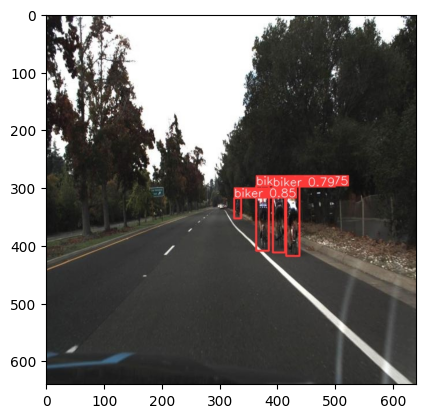

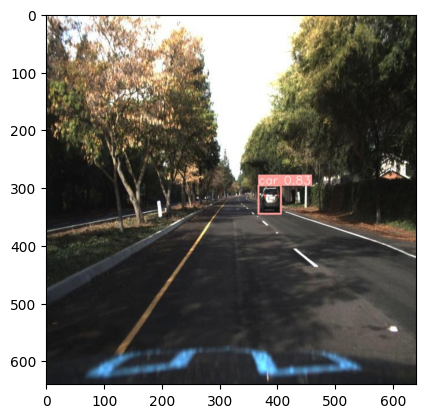

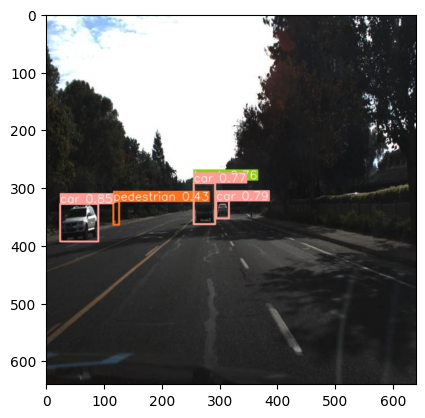

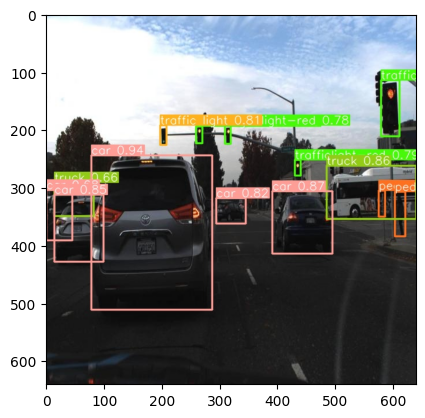

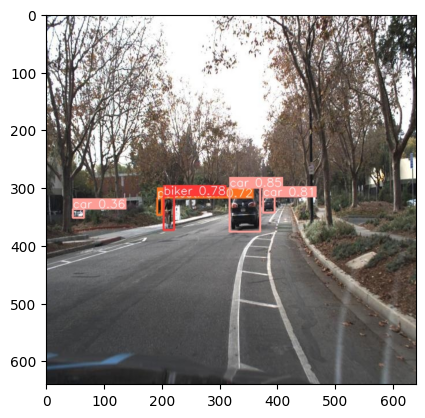

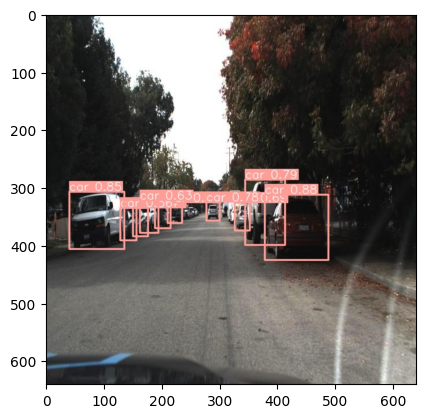

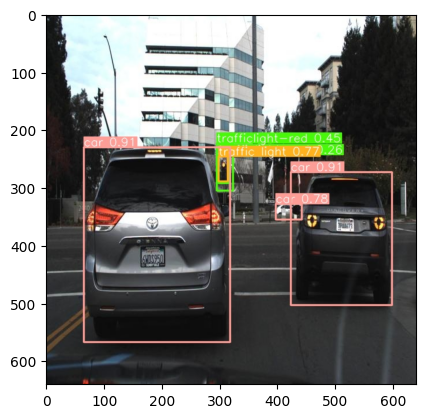

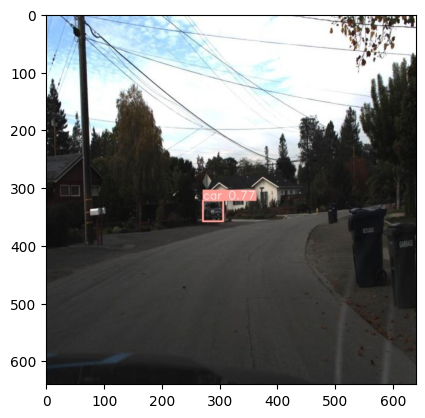

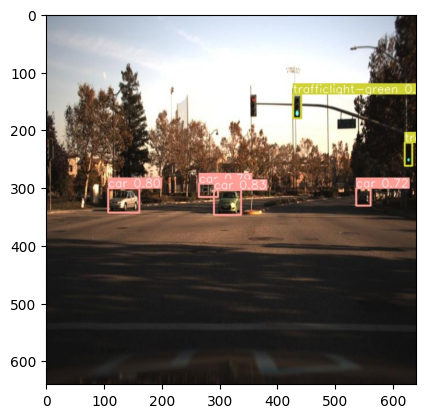

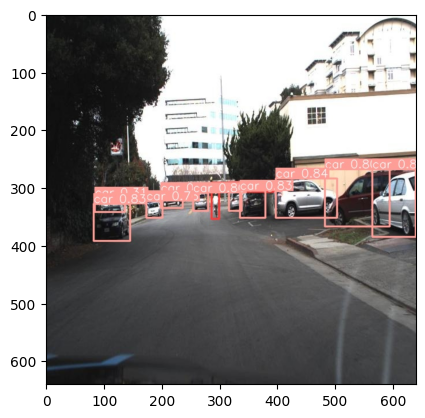

In [15]:
# Show prediction results
%matplotlib inline

predicitions = glob.glob(os.path.join(WORK_DIR, 'runs/detect/predict', '*'))

n = 10

for i in range(n):
    idx = np.random.randint(0, len(predicitions))
    image = Image.open(predicitions[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()


<a href='runs/detect/predict/'> Download File </a>